# Fmrate prediction

In [86]:
import numpy as np
import uproot as ur
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd
import copy
import sys

from scipy import stats
from numba import njit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

## Split data

In [71]:
def train_val_test_split(X, y, val_size=0.2, test_size=0.2, random_state=42, shuffle=True):
    assert val_size + test_size < 1, "There's no training examples, need some training examples" 
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size, 
                                                        random_state=random_state, 
                                                        shuffle=shuffle)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                      test_size=val_size/(1-test_size), 
                                                      random_state=random_state,
                                                      shuffle=shuffle) 
    # 1/4 = 20/80 = 0.2/(0.2+0.6)
    # Reset indices of df:
    X_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [72]:
data_df = pd.read_csv("../data/fmrate_dataset.csv")

In [73]:
data_df

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,...,rate[2],rate[3],rate[4],rate[5],rate[6],rate[7],rate[8],rate[9],rate[10],rate[11]
0,1470.0615,340.447390,34.386083,39.438089,-36.972051,33.6,69.831172,41.997769,1.483525e+09,8323.0,...,9.175346,2.398795,0.000000,144902.177530,45712.324384,13845.953080,8356.903924,2438.513754,239474.841087,11744.694832
1,1530.0690,344.948899,34.294665,40.152989,-39.919769,33.7,74.831447,42.486682,1.483526e+09,7893.0,...,12.970488,0.977676,0.000000,153318.962241,48581.165475,14829.628152,8883.639889,2635.849803,253521.561985,12586.337166
2,1590.0730,349.471306,34.021657,40.929578,-42.707255,33.8,79.894200,42.732372,1.483526e+09,8616.0,...,22.955236,6.997275,1.440506,153940.468185,48497.795501,14516.429778,8760.980672,2490.574534,253464.050166,12447.241383
3,1650.0795,353.998464,33.578979,41.795244,-45.338568,33.9,84.978480,42.730839,1.483526e+09,7961.0,...,10.679009,0.000000,0.000000,153332.226326,48214.601357,14549.504555,8738.605590,2533.338163,253057.586337,12516.820358
4,1710.0840,358.501904,32.952299,42.798457,-47.833584,34.0,90.041732,42.481912,1.483526e+09,7857.0,...,10.958631,1.675759,0.000000,152311.547934,48175.919461,14699.423072,8731.916784,2473.908613,249121.718756,12395.476760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64677,0.0000,70.353786,-29.267651,100.477836,57.059095,34.3,102.504047,-39.787169,1.489744e+09,19174.0,...,20.845726,0.000000,0.000000,421381.161376,91254.976413,18187.144117,10166.549068,2520.873146,675029.015069,17152.212729
64678,0.0000,74.590641,-30.153896,98.939578,57.476146,34.3,107.186486,-40.836773,1.489745e+09,21385.0,...,15.407485,0.498087,0.000000,493352.601640,91960.388522,18408.719222,10437.676092,2687.357262,787895.241321,17259.848070
64679,0.0000,78.749244,-30.790904,97.410511,57.831276,34.4,111.848502,-41.645589,1.489745e+09,22211.0,...,19.850554,3.139644,0.000000,381079.484260,80642.260970,19433.904554,10932.724402,2747.667543,648988.657261,17762.022693
64680,0.0000,83.137941,-31.353051,95.710760,58.025618,34.4,116.784951,-42.257397,1.489745e+09,23759.0,...,19.554150,1.672301,0.000000,339358.361808,78711.053376,20140.309630,11353.850287,2851.749516,594285.018883,18096.580711


In [74]:
X = data_df.drop(columns=[f"rate[{i}]" for i in range(12)])
y = data_df[[f"rate[{i}]" for i in range(12)]]

In [75]:
X

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,is_orbit_up,altitude,sun,sun_spot,B_r,B_theta,B_phi
0,1470.0615,340.447390,34.386083,39.438089,-36.972051,33.6,69.831172,41.997769,1.483525e+09,8323.0,True,376.131102,19.0,72.4,-39193.080835,-20979.807253,1729.812864
1,1530.0690,344.948899,34.294665,40.152989,-39.919769,33.7,74.831447,42.486682,1.483526e+09,7893.0,True,375.738921,19.0,72.4,-40101.703258,-20889.235541,1549.857910
2,1590.0730,349.471306,34.021657,40.929578,-42.707255,33.8,79.894200,42.732372,1.483526e+09,8616.0,True,375.379107,19.0,72.4,-40806.117699,-20916.030570,1278.673806
3,1650.0795,353.998464,33.578979,41.795244,-45.338568,33.9,84.978480,42.730839,1.483526e+09,7961.0,False,375.063898,19.0,72.4,-41264.432292,-21067.198077,915.193701
4,1710.0840,358.501904,32.952299,42.798457,-47.833584,34.0,90.041732,42.481912,1.483526e+09,7857.0,False,374.784932,19.0,72.4,-41434.644115,-21347.676257,468.751810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64677,0.0000,70.353786,-29.267651,100.477836,57.059095,34.3,102.504047,-39.787169,1.489744e+09,19174.0,False,388.099321,5.0,70.5,47355.553109,-13418.374197,-4356.912817
64678,0.0000,74.590641,-30.153896,98.939578,57.476146,34.3,107.186486,-40.836773,1.489745e+09,21385.0,False,387.793437,5.0,70.5,48500.835937,-13218.504481,-3548.625486
64679,0.0000,78.749244,-30.790904,97.410511,57.831276,34.4,111.848502,-41.645589,1.489745e+09,22211.0,False,387.483253,5.0,70.5,49390.650877,-13125.342373,-2692.293649
64680,0.0000,83.137941,-31.353051,95.710760,58.025618,34.4,116.784951,-42.257397,1.489745e+09,23759.0,False,387.169976,5.0,70.5,50058.811556,-13141.213561,-1747.318052


In [76]:
y

,rate[0],rate[1],rate[2],rate[3],rate[4],rate[5],rate[6],rate[7],rate[8],rate[9],rate[10],rate[11]
0,56941.760321,1264.897761,9.175346,2.398795,0.000000,144902.177530,45712.324384,13845.953080,8356.903924,2438.513754,239474.841087,11744.694832
1,58123.694878,1296.198799,12.970488,0.977676,0.000000,153318.962241,48581.165475,14829.628152,8883.639889,2635.849803,253521.561985,12586.337166
2,58244.963030,1278.068894,22.955236,6.997275,1.440506,153940.468185,48497.795501,14516.429778,8760.980672,2490.574534,253464.050166,12447.241383
3,58325.603325,1293.320262,10.679009,0.000000,0.000000,153332.226326,48214.601357,14549.504555,8738.605590,2533.338163,253057.586337,12516.820358
4,57655.444528,1226.298473,10.958631,1.675759,0.000000,152311.547934,48175.919461,14699.423072,8731.916784,2473.908613,249121.718756,12395.476760
...,...,...,...,...,...,...,...,...,...,...,...,...
64677,166768.282730,3383.497463,20.845726,0.000000,0.000000,421381.161376,91254.976413,18187.144117,10166.549068,2520.873146,675029.015069,17152.212729
64678,201208.113638,3954.093915,15.407485,0.498087,0.000000,493352.601640,91960.388522,18408.719222,10437.676092,2687.357262,787895.241321,17259.848070
64679,168499.665785,3143.015693,19.850554,3.139644,0.000000,381079.484260,80642.260970,19433.904554,10932.724402,2747.667543,648988.657261,17762.022693
64680,157398.392828,2854.361729,19.554150,1.672301,0.000000,339358.361808,78711.053376,20140.309630,11353.850287,2851.749516,594285.018883,18096.580711


In [77]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y,
                                                                      val_size=0.2,
                                                                      test_size=0.2,
                                                                      random_state=42,
                                                                      shuffle=True)

In [78]:
[el.shape for el in [X_train, X_val, X_test, y_train, y_val, y_test]]

[(38808, 17), (12937, 17), (12937, 17), (38808, 12), (12937, 12), (12937, 12)]

**We're not allowed to use the test set to make any decision !!**

## Preprocessing

- https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling
- https://youtu.be/juEOOQntrd0

## Basic Fully Connected NN

In [161]:
estimator = MLPRegressor(hidden_layer_sizes=[100, 100], random_state=42, max_iter=500)
pipe = make_pipeline(StandardScaler(), estimator)

In [162]:
pipe.fit(X_train, y_train)

/home/zenchiyu/.local/share/virtualenvs/POLAR-background-prediction-g2F1Og_3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=[100, 100], max_iter=500,
                              random_state=42))])

In [163]:
pred = pipe.predict(X_val)
pd.DataFrame(pred)

,0,1,2,3,4,5,6,7,8,9,10,11
0,62235.849613,1527.203310,13.288652,2.324840,7.596849,156771.741135,47307.670330,13148.856864,7536.779196,2037.957449,263883.086563,11554.275045
1,99339.122500,2713.551438,25.540666,8.250170,4.449136,281316.945319,73139.616556,19319.639848,11502.138081,3488.805084,426614.470175,17032.544498
2,53839.117170,1378.990866,13.953356,2.276681,5.455325,146100.781416,43208.818194,12610.081795,7414.713880,2126.106486,235269.443222,10921.081503
3,47413.529873,1203.781908,10.705962,4.139779,0.463888,130852.765141,33699.110691,8389.093729,4951.291352,1486.065832,197956.993089,7494.964827
4,55151.075219,1344.566642,18.082672,3.521948,3.624778,162185.178123,42645.579096,11628.262565,6713.108018,1826.261838,246636.811967,10042.491749
...,...,...,...,...,...,...,...,...,...,...,...,...
12932,98208.577766,312.551621,23.864150,9.822384,4.804687,183547.721749,50575.883861,16460.194447,9295.095240,2409.967029,393186.375716,14842.967561
12933,39389.388351,1131.232350,12.200385,2.765487,1.656462,115851.659943,32122.979383,8761.325299,5218.616000,1566.445649,171004.678462,7531.296557
12934,50033.957545,1364.178499,11.542474,3.425656,3.358396,138475.686341,35848.482599,9301.202843,5510.047453,1661.578243,209596.775987,8222.244701
12935,46156.085564,1073.753592,16.613362,3.863909,3.662085,142722.075549,36070.032480,10929.247538,6613.920791,1994.120173,209833.920743,9224.554165


In [164]:
y_val

,rate[0],rate[1],rate[2],rate[3],rate[4],rate[5],rate[6],rate[7],rate[8],rate[9],rate[10],rate[11]
0,63714.487231,1223.650552,9.334296,1.105197,0.000000,151092.152316,44955.312493,12165.963757,7023.230979,1912.205616,260762.629681,10760.596886
1,67711.925025,1607.662435,16.864431,1.100319,0.000000,183076.529341,62626.598177,18316.663814,10639.850081,2858.243524,297125.316997,15933.804070
2,55774.134068,1198.781719,12.524857,2.399933,0.000000,147956.343629,43724.464878,12372.556492,7251.458890,2012.472125,239765.939522,10568.263605
3,47059.098109,1065.865044,8.746947,1.429096,0.000000,135892.020199,33874.406058,8553.290799,4992.267112,1403.965876,205017.112127,7774.789680
4,54282.384588,1134.889051,11.642484,2.674487,0.000000,151723.024742,43410.263887,12553.080129,7342.095191,1950.565334,232745.662310,10490.552228
...,...,...,...,...,...,...,...,...,...,...,...,...
12932,116918.264377,1886.088149,20.081289,3.532154,0.000000,199967.189814,62288.267914,16758.780412,9594.698500,2463.608980,415697.808169,15501.675469
12933,39994.685070,952.063362,3.009176,1.754939,0.000000,121876.827317,30528.564993,8202.976469,4871.864938,1372.358619,178714.044216,6995.930446
12934,47145.563931,1016.822680,9.931920,0.954286,0.000000,136680.763003,34549.799903,9396.764113,5637.066540,1684.266364,203431.800433,8156.340244
12935,40088.039053,1044.381334,11.241683,1.739397,0.000000,135010.976846,41569.797539,13708.903615,8488.094385,2680.193162,190127.748876,11045.473511


### Visualization

Let's only look at `rate[0]`

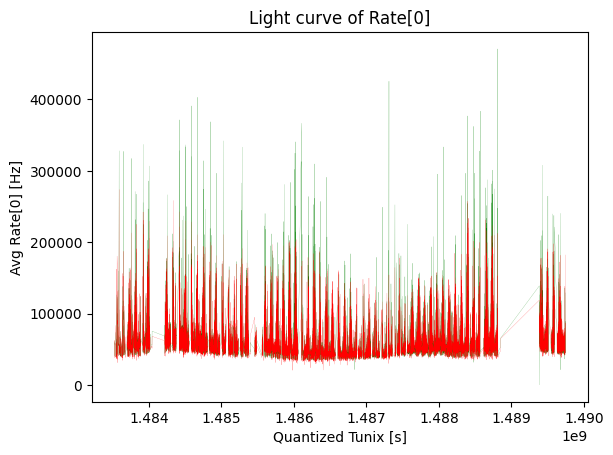

In [180]:
argsort = np.argsort(X_val["unix_time"])[::-1]
sorted_time_val = X_val["unix_time"][argsort]
sorted_y_val_r0 = y_val.loc[:, "rate[0]"][argsort]
sorted_val_r0 = pred[:, 0][argsort]

plt.plot(sorted_time_val, sorted_y_val_r0, '-g', linewidth=0.1)
plt.plot(sorted_time_val, sorted_val_r0, '-r', linewidth=0.1)
plt.xlabel("Quantized Tunix [s]")
plt.ylabel("Avg Rate[0] [Hz]")  # Nb. photons per second (averaged over each bin)
plt.title("Light curve of Rate[0]")
plt.show()

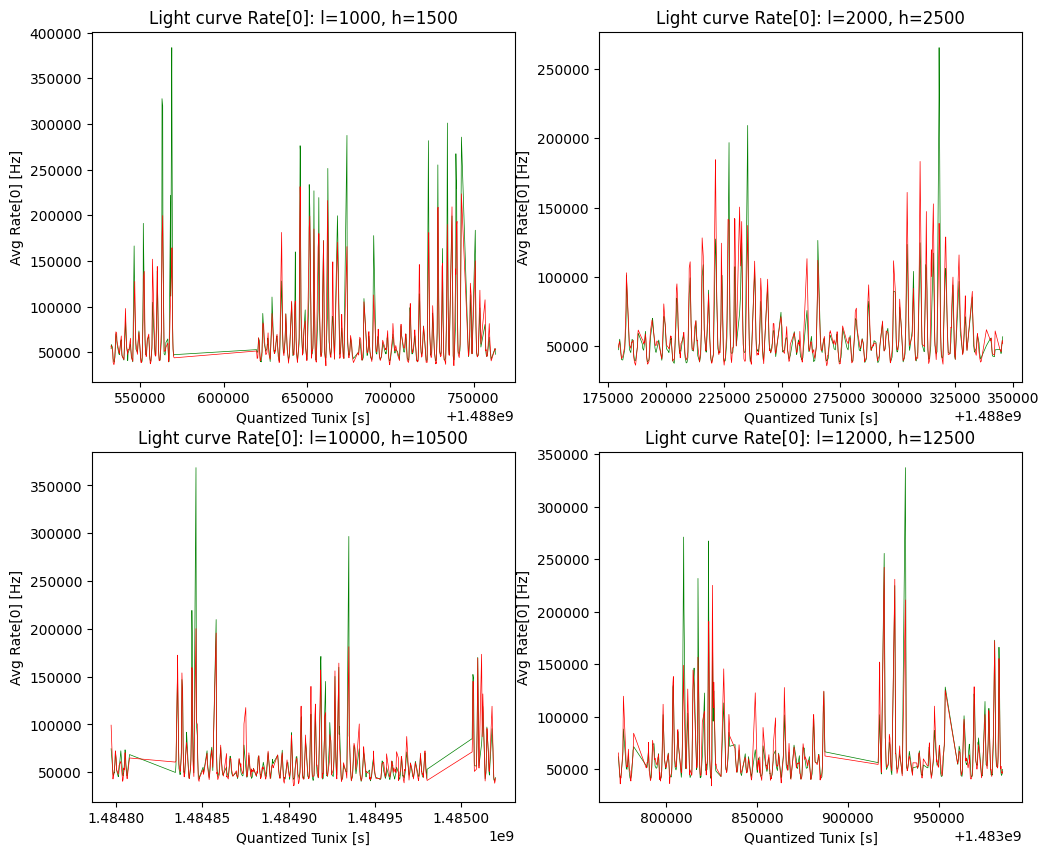

In [166]:
low_n = 1000
high_n = 1500
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, (low_n, high_n) in enumerate([(1000, 1500), (2000, 2500),
                                   (10000, 10500), (12000, 12500)]):
    axs[i//2, i%2].plot(sorted_time_val[low_n:high_n], sorted_y_val_r0[low_n:high_n], '-g', linewidth=0.5)
    axs[i//2, i%2].plot(sorted_time_val[low_n:high_n], sorted_val_r0[low_n:high_n], '-r', linewidth=0.5)
    axs[i//2, i%2].set_xlabel("Quantized Tunix [s]")
    axs[i//2, i%2].set_ylabel("Avg Rate[0] [Hz]")  # Nb. photons per second (averaged over each bin)
    axs[i//2, i%2].set_title(f"Light curve Rate[0]: l={low_n}, h={high_n}")
plt.show()

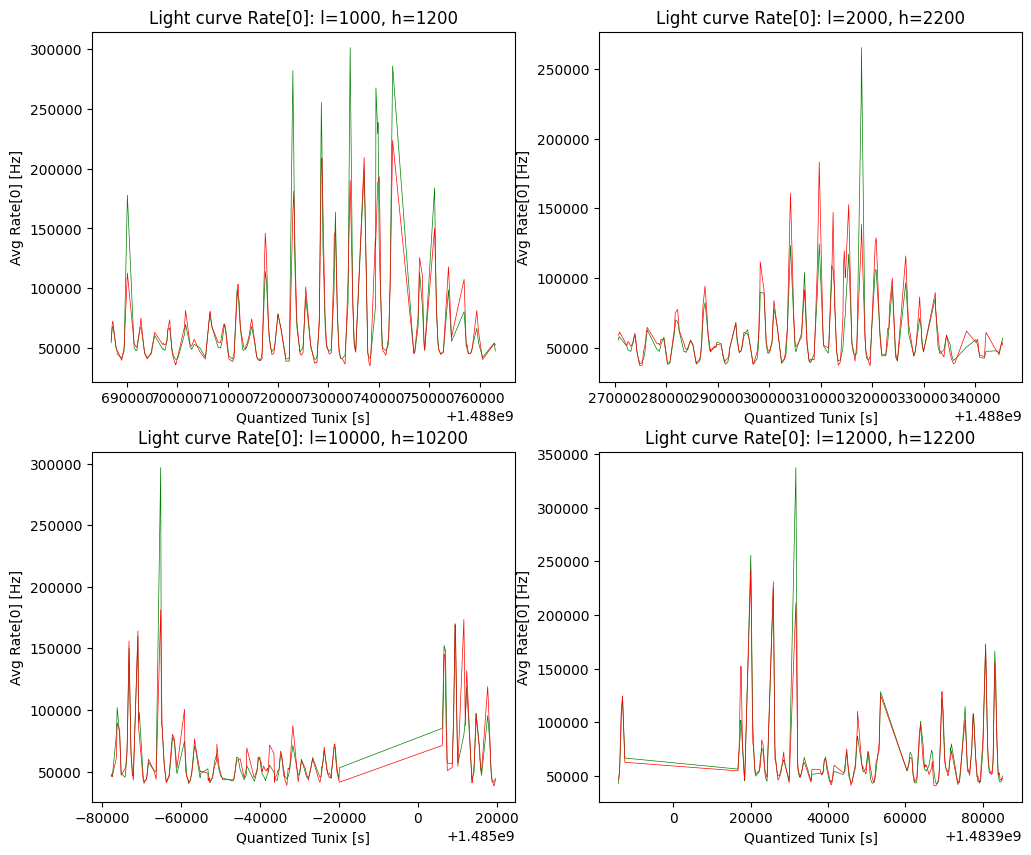

In [189]:
low_n = 1000
high_n = 1500
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, (low_n, high_n) in enumerate([(1000, 1200), (2000, 2200),
                                   (10000, 10200), (12000, 12200)]):
    axs[i//2, i%2].plot(sorted_time_val[low_n:high_n], sorted_y_val_r0[low_n:high_n], '-g', linewidth=0.5)
    axs[i//2, i%2].plot(sorted_time_val[low_n:high_n], sorted_val_r0[low_n:high_n], '-r', linewidth=0.5)
    axs[i//2, i%2].set_xlabel("Quantized Tunix [s]")
    axs[i//2, i%2].set_ylabel("Avg Rate[0] [Hz]")  # Nb. photons per second (averaged over each bin)
    axs[i//2, i%2].set_title(f"Light curve Rate[0]: l={low_n}, h={high_n}")
plt.show()

In [168]:
fitted_mlp = pipe["mlpregressor"]

In [169]:
np.sqrt(fitted_mlp.loss_), np.std(sorted_y_val_r0)

(17192.53817974061, 33781.365942676144)

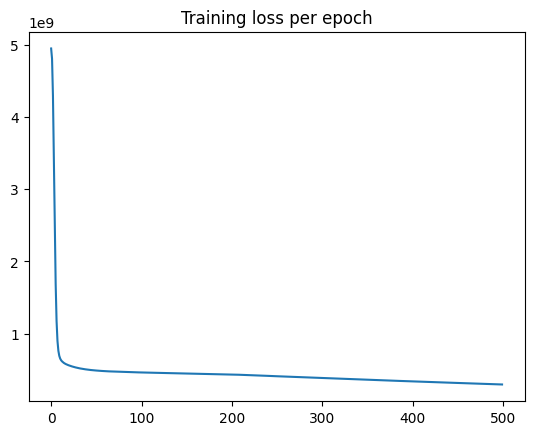

In [170]:
plt.plot(fitted_mlp.loss_curve_)
plt.title("Training loss per epoch")
plt.show()

The loss is still quiet huge

In [171]:
fitted_mlp.coefs_

[array([[-1.07915098,  1.52660875,  0.29973014, ..., -1.26626868,
         -3.80445383, -3.6382522 ],
        [-2.50658786,  3.86882083,  2.74043743, ...,  0.18597205,
          1.82392047,  2.94445604],
        [ 0.87501047, -2.04859193, -0.68958016, ..., -2.04621957,
         -0.75425964, -0.07482031],
        ...,
        [-4.5948469 , -1.84764922, -2.88909846, ..., -4.17757271,
         -2.92244795, -3.91736637],
        [ 6.33079485,  2.14505713,  2.34367981, ..., -8.54396149,
          3.95746074,  4.04994063],
        [ 0.0342749 , -0.25016838,  0.0114012 , ..., -5.32510268,
          2.50244926,  1.40382136]]),
 array([[ 3.90380502e+00,  1.77351423e+00, -3.11106355e-01, ...,
          3.61969658e+00,  3.23118254e+00, -2.43053170e-07],
        [ 3.57112305e+00,  3.38426273e+00,  9.51501783e-01, ...,
          3.37870104e+00, -1.04240934e+00, -7.77409082e-12],
        [ 3.10050512e+00,  1.29767949e+00,  1.12533620e-01, ...,
          3.21117500e+00, -5.33694458e+00, -7.72631390e-

**TODO: try compare it with linear regression only using `fe_cosmic`. Also show validation loss for each epoch !**

### Residual plot
**Warning: we're gonna use the whole dataset, careful about data leakage**

In [191]:
# predict using the whole X.. just to observe the residuals
pred_X = pipe.predict(X)

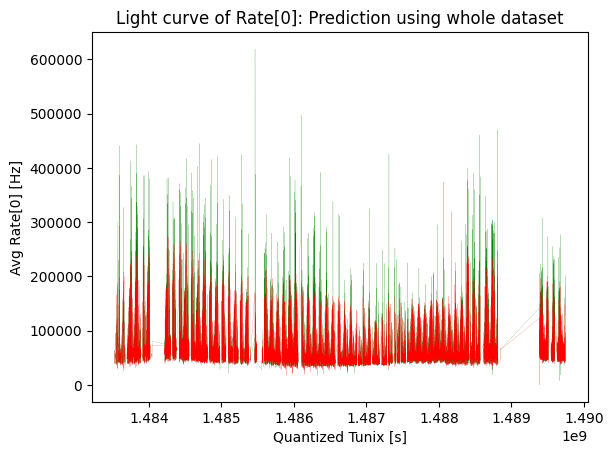

In [192]:
plt.plot(X["unix_time"], y.loc[:, "rate[0]"], '-g', linewidth=0.1)
plt.plot(X["unix_time"], pred_X[:, 0], '-r', linewidth=0.1)
plt.xlabel("Quantized Tunix [s]")
plt.ylabel("Avg Rate[0] [Hz]")  # Nb. photons per second (averaged over each bin)
plt.title("Light curve of Rate[0]: Prediction using whole dataset")
plt.show()

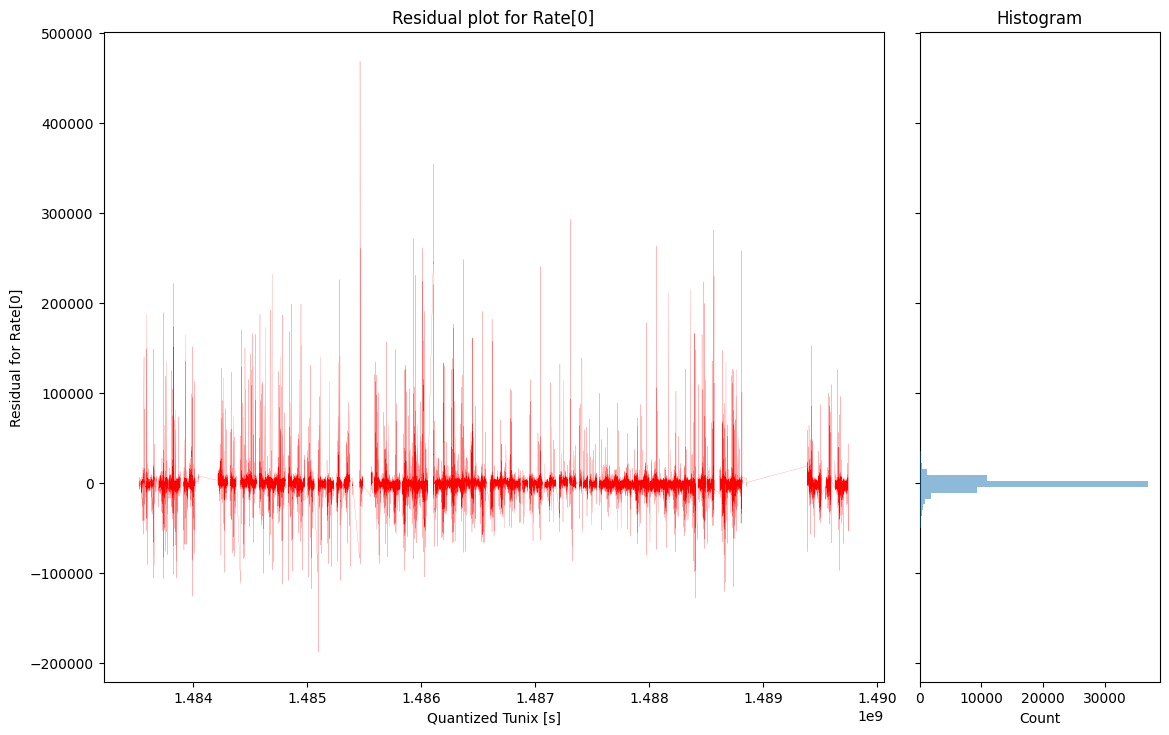

In [193]:
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.03
rect_residuals = [left, bottom, width, height]
rect_histy = [left + width + spacing, bottom, 0.2, height]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes(rect_residuals)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

ax.plot(X["unix_time"], y.loc[:, "rate[0]"]-pred_X[:, 0], '-r', linewidth=0.1)
ax.set_xlabel("Quantized Tunix [s]")
ax.set_ylabel("Residual for Rate[0]")  # Nb. photons per second (averaged over each bin)
ax.set_title("Residual plot for Rate[0]")



ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.set_title("Histogram")
ax_histy.set_xlabel("Count")


_ = ax_histy.hist(y.loc[:, "rate[0]"]-pred_X[:, 0], bins=100, orientation='horizontal', alpha=0.5, zorder=np.inf)


plt.show()

**TODO: try compare it with linear regression only using `fe_cosmic`. Also show validation loss for each epoch !**

## Linear regression using `fe_cosmic`, to predict just `rate[0]`

In [179]:
result = stats.linregress(X_train["fe_cosmic"], y_train["rate[0]"])

print(f"Slope a: {result.slope}, Intercept b: {result.intercept},\nR^2: {result.rvalue**2}, p-value: {result.pvalue}")
print("\n"+f"std_a: {result.stderr}, std_b: {result.intercept_stderr}")

Slope a: 5.472109778951114, Intercept b: 25753.519783965356,
R^2: 0.5258888074026239, p-value: 0.0

std_a: 0.02637536642735104, std_b: 206.73566779100656


In [182]:
pred_linregress = X_test["fe_cosmic"]*result.slope + result.intercept

### Visualization

Let's only look at `rate[0]`

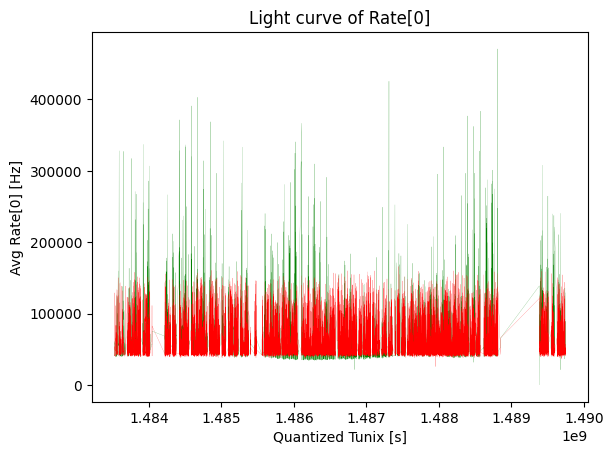

In [183]:
# argsort = np.argsort(X_val["unix_time"])[::-1]
# sorted_time_val = X_val["unix_time"][argsort]
# sorted_y_val_r0 = y_val.loc[:, "rate[0]"][argsort]
sorted_val_r0_linregress = pred_linregress[argsort]

plt.plot(sorted_time_val, sorted_y_val_r0, '-g', linewidth=0.1)
plt.plot(sorted_time_val, sorted_val_r0_linregress, '-r', linewidth=0.1)
plt.xlabel("Quantized Tunix [s]")
plt.ylabel("Avg Rate[0] [Hz]")  # Nb. photons per second (averaged over each bin)
plt.title("Light curve of Rate[0]")
plt.show()

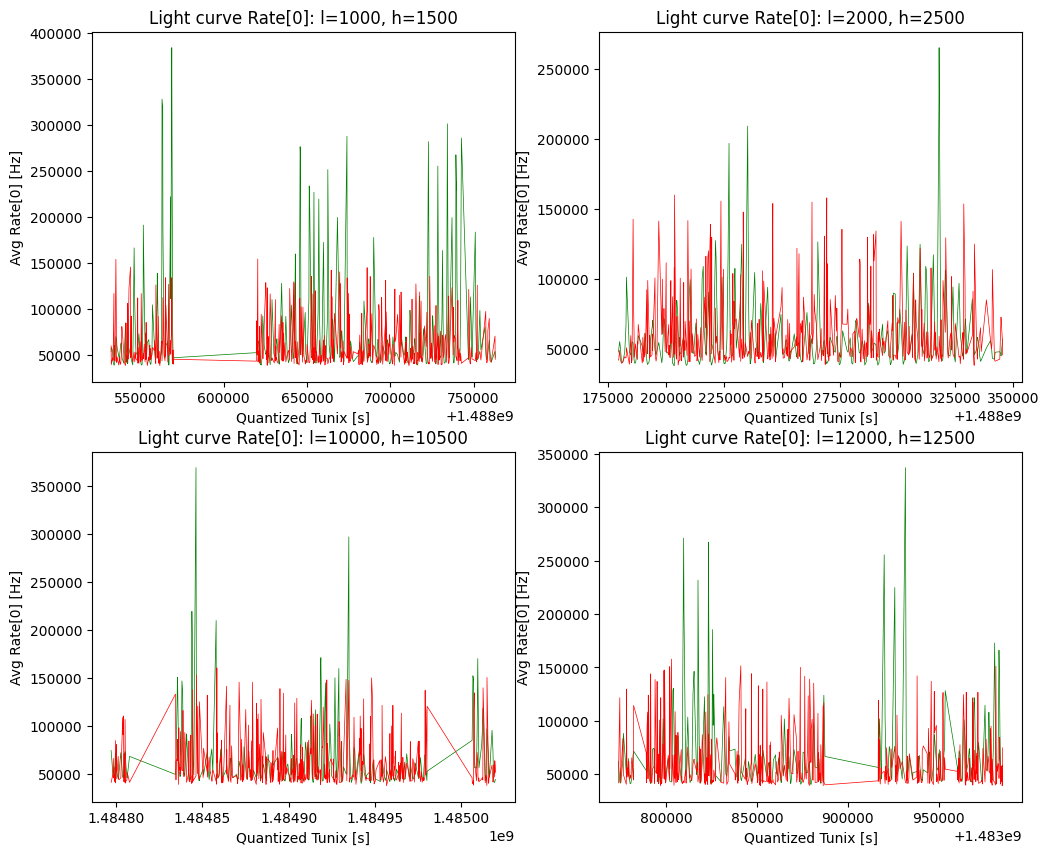

In [184]:
low_n = 1000
high_n = 1500
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, (low_n, high_n) in enumerate([(1000, 1500), (2000, 2500),
                                   (10000, 10500), (12000, 12500)]):
    axs[i//2, i%2].plot(sorted_time_val[low_n:high_n], sorted_y_val_r0[low_n:high_n], '-g', linewidth=0.5)
    axs[i//2, i%2].plot(sorted_time_val[low_n:high_n], sorted_val_r0_linregress[low_n:high_n], '-r', linewidth=0.5)
    axs[i//2, i%2].set_xlabel("Quantized Tunix [s]")
    axs[i//2, i%2].set_ylabel("Avg Rate[0] [Hz]")  # Nb. photons per second (averaged over each bin)
    axs[i//2, i%2].set_title(f"Light curve Rate[0]: l={low_n}, h={high_n}")
plt.show()

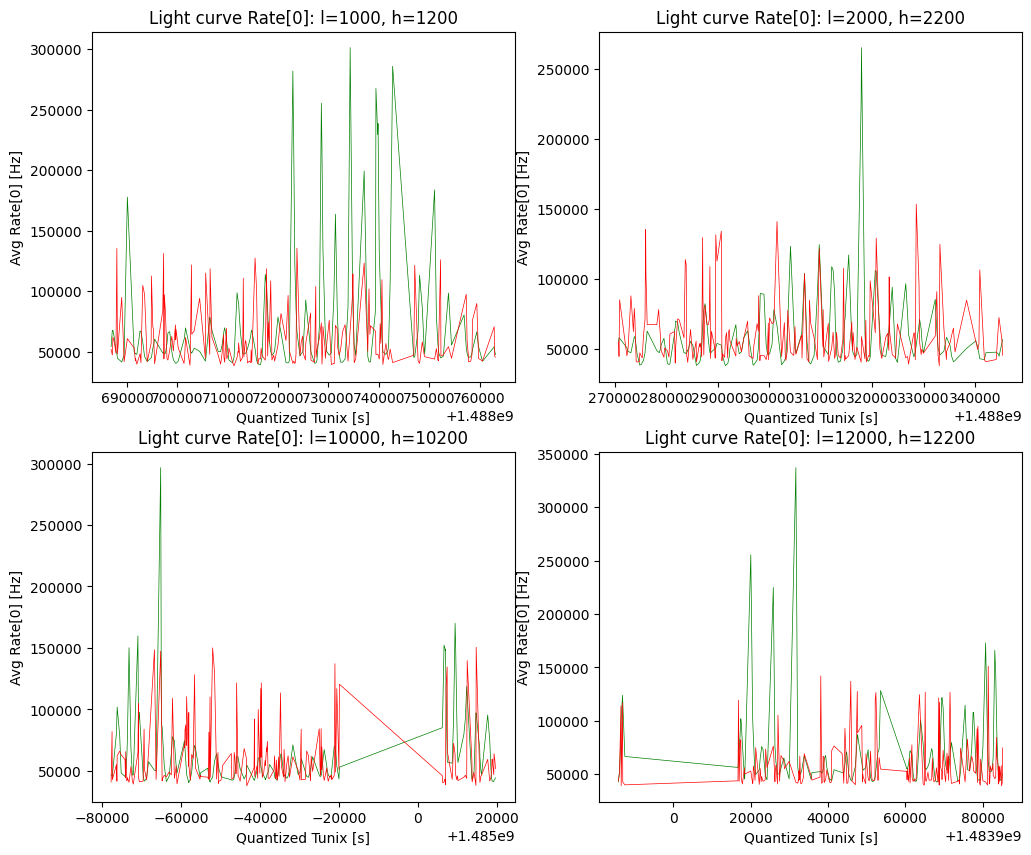

In [188]:
low_n = 1000
high_n = 1500
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, (low_n, high_n) in enumerate([(1000, 1200), (2000, 2200),
                                   (10000, 10200), (12000, 12200)]):
    axs[i//2, i%2].plot(sorted_time_val[low_n:high_n], sorted_y_val_r0[low_n:high_n], '-g', linewidth=0.5)
    axs[i//2, i%2].plot(sorted_time_val[low_n:high_n], sorted_val_r0_linregress[low_n:high_n], '-r', linewidth=0.5)
    axs[i//2, i%2].set_xlabel("Quantized Tunix [s]")
    axs[i//2, i%2].set_ylabel("Avg Rate[0] [Hz]")  # Nb. photons per second (averaged over each bin)
    axs[i//2, i%2].set_title(f"Light curve Rate[0]: l={low_n}, h={high_n}")
plt.show()

**TODO: measure the loss using linear regression instead of multi-layer perceptron**

In [169]:
# np.sqrt(fitted_mlp.loss_), np.std(sorted_y_val_r0)

(17192.53817974061, 33781.365942676144)

### Residual plot
**Warning: we're gonna use the whole dataset, careful about data leakage**

In [194]:
# predict using the whole X (fe_cosmic).. just to observe the residuals
pred_X = X["fe_cosmic"]*result.slope + result.intercept

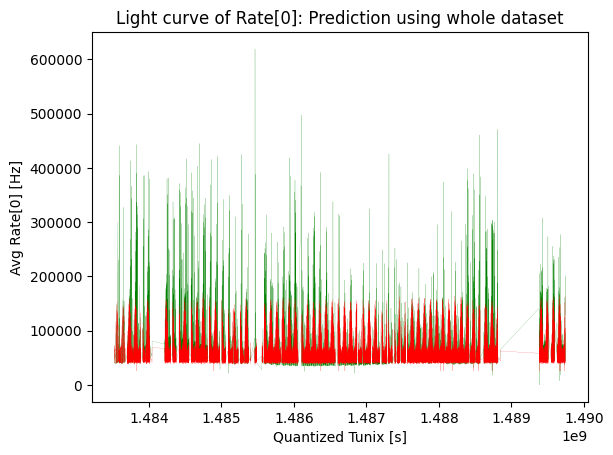

In [198]:
plt.plot(X["unix_time"], y.loc[:, "rate[0]"], '-g', linewidth=0.1)
plt.plot(X["unix_time"], pred_X, '-r', linewidth=0.1)
plt.xlabel("Quantized Tunix [s]")
plt.ylabel("Avg Rate[0] [Hz]")  # Nb. photons per second (averaged over each bin)
plt.title("Light curve of Rate[0]: Prediction using whole dataset")
plt.show()

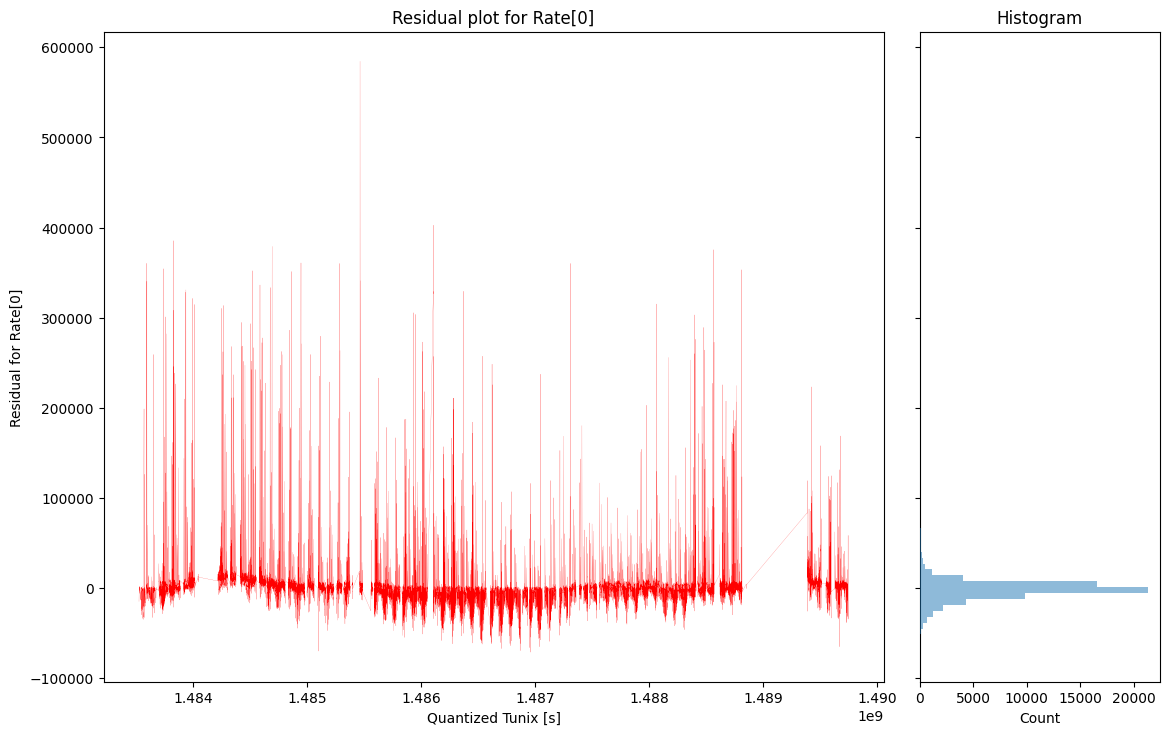

In [200]:
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.03
rect_residuals = [left, bottom, width, height]
rect_histy = [left + width + spacing, bottom, 0.2, height]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes(rect_residuals)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

ax.plot(X["unix_time"], y.loc[:, "rate[0]"]-pred_X, '-r', linewidth=0.1)
ax.set_xlabel("Quantized Tunix [s]")
ax.set_ylabel("Residual for Rate[0]")  # Nb. photons per second (averaged over each bin)
ax.set_title("Residual plot for Rate[0]")



ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.set_title("Histogram")
ax_histy.set_xlabel("Count")


_ = ax_histy.hist(y.loc[:, "rate[0]"]-pred_X, bins=100, orientation='horizontal', alpha=0.5, zorder=np.inf)


plt.show()

**TODO: try compare via evaluation measures with NN**